In [11]:
import sys
!pip install pandas
!pip install numpy
!pip3 install datapane
!pip install plotly
!pip install pymysql

In [12]:
# import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp
import pymysql
import warnings
import pymysql
import sys
import os
warnings.filterwarnings('ignore')


In [13]:
host = 'database-1.cwtfy2nqptyn.us-east-1.rds.amazonaws.com'
user = 'admin'
password = 'PriyanshSoni'
database = 'Hospital_Management'

connection = pymysql.connect(host=host, user=user, passwd=password, database=database)
with connection:
    cur = connection.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()
    print("Database version: {} ".format(version[0]))

Database version: 8.0.33 


In [14]:
def run_query(q: str) -> pd.DataFrame:
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [15]:
def show_tables() -> pd.DataFrame:
    q = """
          SELECT table_name
          FROM information_schema.tables
          WHERE table_schema = 'Hospital_Management' AND table_type = 'BASE TABLE';
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables['TABLE_NAME']]

tables

,TABLE_NAME,row_count
0,Appointment,26
1,Department,5
2,Doctor,12
3,EmergencyPatient,2
4,InPatient,5
5,Insurance,20
6,Medical_Record,25
7,OutPatient,3
8,Patient,25
9,Prescription,26


In [16]:
patient_type = """
SELECT Patient.PatientType, COUNT(Patient.Patient_ID) AS PatientCount
FROM Patient
WHERE Patient.PatientType IS NOT NULL
GROUP BY Patient.PatientType;
"""

ptype = run_query(patient_type)
ptype
ptype.sort_values("PatientCount", inplace=True)
ptype_bar = px.bar(
    ptype, x="PatientType", y="PatientCount", text="PatientCount", orientation="v"
)

ptype_bar.update_traces(texttemplate="%{text:.1f}")
ptype_bar.update_traces(marker_color='orange')
chart_width = 800  # Set width
chart_height = 500  # Set height
ptype_bar.update_layout(
    width=chart_width,
    height=chart_height,
)
ptype_bar.show()

In [17]:
import datapane as dp

patient_doctor_query = """
SELECT
    A.Patient_ID,
    A.Doctor_ID,
    D.First_Name AS Doctor_First_Name,
    D.Last_Name AS Doctor_Last_Name,
    DP.Department_Name,
    P.First_Name AS Patient_First_Name,
    P.Last_Name AS Patient_Last_Name,
    A.Visit_Type
FROM
    Appointment A
JOIN
    Doctor D ON A.Doctor_ID = D.Doctor_ID
JOIN
    Patient P ON A.Patient_ID = P.Patient_ID
JOIN
    Department DP ON D.Department_ID = DP.Department_ID
WHERE
    A.Visit_Type IN ('Check-up', 'Follow-up');
"""


output_table = run_query(patient_doctor_query)

dp.DataTable(output_table)

In [18]:
import datapane as dp

Insurance_Status = """
WITH InsuranceStatus AS(
SELECT
		I.Patient_ID AS Patient_ID,
        I.Insurance_Provider AS Insurance_Provider,
        CASE
            WHEN I.Coverage_End_Date >= CURDATE() THEN 'Active'
            WHEN I.Insurance_ID IS NOT NULL AND I.Coverage_End_Date < CURDATE() THEN 'Inactive'
            ELSE 'No Insurance'
        END AS InsuranceStatus
    FROM
        Insurance I)
select InsuranceStatus.Insurance_Provider,
    count(InsuranceStatus.Patient_ID) AS "No of patients",
    SUM(CASE WHEN InsuranceStatus.InsuranceStatus = 'Active' THEN 1 ELSE 0 END) AS ActiveCount,
    SUM(CASE WHEN InsuranceStatus.InsuranceStatus = 'Inactive' THEN 1 ELSE 0 END) AS InactiveCount
FROM
    InsuranceStatus
GROUP BY
    InsuranceStatus.Insurance_Provider;
"""

query_output = run_query(Insurance_Status)
data = dp.DataTable(query_output)

df_melted = pd.melt(query_output, id_vars='Insurance_Provider', var_name='Category', value_name='Count')

fig = px.bar(df_melted, x='Insurance_Provider', y='Count', color='Category',
             barmode='group',
             color_discrete_map={'No of patients': 'red', 'ActiveCount': 'black', 'InactiveCount': 'grey'},
             labels={'Count': 'Count'},
             title='Insurance Provider Statistics',
             height=600)

fig.update_xaxes(title_text='Insurance Provider')
fig.update_yaxes(title_text='Count')
chart_width = 700  # Set width
chart_height = 500  # Set height
fig.update_layout(
    width=chart_width,
    height=chart_height,
)
# Show the plot
insurance_plt=fig
insurance_plt.show()



In [19]:
import datapane as dp

querydf = """
SELECT
    mr.Record_ID,
    mr.Record_Date,
    p.Patient_ID,
    p.First_Name AS Patient_First_Name,
    p.Last_Name AS Patient_Last_Name,
    d.Doctor_ID,
    d.First_Name AS Doctor_First_Name,
    d.Last_Name AS Doctor_Last_Name,
    mr.Diagnosis,
    mr.Symptoms
FROM
    Medical_Record mr
JOIN
    Patient p ON mr.Patient_ID = p.Patient_ID
JOIN
    Doctor d ON mr.Doctor_ID = d.Doctor_ID;

"""

querydf = run_query(querydf)

dp.DataTable(querydf)

In [20]:
querydf['Symptoms']

0           Runny nose, sneezing, coughing
1                Fever, body pain, fatigue
2           Stomach pain, bloating, nausea
3                Fever, body pain, fatigue
4                 Severe headache, Fatigue
5                      Redness, itchy eyes
6            High blood pressure, headache
7       Diarrhea, vomiting, abdominal pain
8     social anxiety, repetitive movements
9      Fever,Cough, chest pain, congestion
10         Shortness of breath, congestion
11               Difficulty falling asleep
12    Increased thirst, frequent urination
13             Abdominal pain, indigestion
14                Severe headache, Fatigue
15         Shortness of breath, congestion
16          Fatigue, weight gain, dry skin
17       restlessness,repetitive movements
18    Increased thirst, frequent urination
19               Joint pain, muscle spasms
20               Nervousness, restlessness
21                    Nervousness, fatigue
22          restlessness, chest discomfort
23         

In [21]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import datapane as dp


symptoms_text = " ".join(i for i in querydf.Symptoms)

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=500, height=300, stopwords=stopwords).generate(symptoms_text)

fig = px.imshow(wordcloud.to_array(), binary_string=True)
fig.update_layout(title='Symptoms')
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
chart_width = 800  # Set width
chart_height = 500  # Set height
fig.update_layout(
    width=chart_width,
    height=chart_height,
)
# Show the plot
wordcloud_symptoms=fig
wordcloud_symptoms.show()


In [22]:
import datapane as dp

querysal = """
WITH RankedStaff AS (
    SELECT
        S.Staff_ID,
        S.Department_ID,
        D.Department_Name,
        S.First_Name,
        S.Last_Name,
        S.Staff_Role,
        S.Contact_Number,
        S.Joining_Date,
        S.Salary,
        RANK() OVER (PARTITION BY S.Department_ID ORDER BY S.Salary DESC) AS SalaryRank
    FROM
        Staff S
    JOIN
        Department D ON S.Department_ID = D.Department_ID
)
, DepartmentStats AS (
    SELECT
        Department_ID,
        AVG(Salary) AS AverageSalary,
        MAX(Salary) AS HighestSalary
    FROM
        Staff
    GROUP BY
        Department_ID
)
SELECT
    RS.Staff_ID,
    RS.Department_ID,
    RS.Department_Name,
    RS.First_Name,
    RS.Last_Name,
    RS.Contact_Number,
    RS.Joining_Date,
    round(DS.AverageSalary,2) AS AverageSalary,
    DS.HighestSalary
FROM
    RankedStaff RS
JOIN
    DepartmentStats DS ON RS.Department_ID = DS.Department_ID
WHERE
    RS.SalaryRank = 1;
"""

querysal = run_query(querysal)

dp.DataTable(querysal)

In [23]:
querysal['Department_Name']

0        Pediatric
1       Laboratory
2          Nursing
3    Neuro_Imaging
4         Pharmacy
Name: Department_Name, dtype: object

In [24]:
fig = go.Figure()

# Plot the average salary on the first y-axis
fig.add_trace(go.Scatter(x=querysal['Department_Name'], y=querysal['AverageSalary'],
                         mode='lines+markers',
                         name='Average Salary',
                         marker=dict(color='blue')))

# Create a second y-axis for the highest salary
fig.add_trace(go.Scatter(x=querysal['Department_Name'], y=querysal['HighestSalary'],
                         mode='lines+markers',
                         name='Highest Salary',
                         marker=dict(color='red')))

# Add legend
fig.update_layout(legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

# Set labels and title
fig.update_layout(xaxis_title='Department Name', yaxis_title='Salary')
fig.update_layout(title='Dual Axis Line Chart - Average and Highest Salary by Department')
chart_width = 800  # Set width
chart_height = 500  # Set height
fig.update_layout(
    width=chart_width,
    height=chart_height,
)
# Show the plot
salary_fig=fig
salary_fig.show()

In [25]:
import datapane as dp

querydocvisit = """
SELECT
    d.Doctor_ID,
    d.First_Name AS Doctor_First_Name,
    d.Last_Name AS Doctor_Last_Name,
    a.Visit_Type,
    COUNT(*) AS Appointment_Count
FROM
    Doctor d
JOIN
    Appointment a ON d.Doctor_ID = a.Doctor_ID
GROUP BY
    d.Doctor_ID, d.First_Name, d.Last_Name, a.Visit_Type;

"""

querydocvisit = run_query(querydocvisit)

dp.DataTable(querydocvisit)

In [26]:
df_pivot = querydocvisit.pivot_table(index=['Doctor_ID', 'Doctor_First_Name'], columns='Visit_Type', values='Appointment_Count', fill_value=0)

df_pivot = df_pivot[df_pivot.sum(axis=1) > 0]

df_pivot = df_pivot.reset_index()

df_melted = pd.melt(df_pivot, id_vars=['Doctor_ID', 'Doctor_First_Name'], var_name='Visit_Type', value_name='Appointment_Count')

fig = go.Figure()

for index, row in df_pivot.iterrows():
    doctor_id = row['Doctor_ID']
    doctor_name = row['Doctor_First_Name']
    appointments = row.drop(['Doctor_ID', 'Doctor_First_Name'])

    fig.add_trace(go.Bar(x=appointments.index, y=appointments.values, name=f'{doctor_id} ({doctor_name})'))

# Adjust layout for better visualization
fig.update_layout(xaxis_title='Doctor ID', yaxis_title='Appointment Count', barmode='stack')
fig.update_layout(title='Appointment Visit Type')


# Show the plot
appointment_visit=fig
fig.show()

In [27]:
Patient = """
SELECT City, State, COUNT(*) AS Patient_Count
FROM Patient
GROUP BY City, State;
"""

Patient = run_query(Patient)

dp.DataTable(Patient)

In [28]:
pip install geopy


In [29]:
from geopy.geocoders import Nominatim
import pandas as pd


# Initialize geolocator
geolocator = Nominatim(user_agent="patient_geocoder")

# Create a function to get coordinates for a city and state
def get_coordinates(row):
    location = geolocator.geocode(f"{row['City']}, {row['State']}")
    if location:
        return pd.Series({'Latitude': location.latitude, 'Longitude': location.longitude})
    else:
        return pd.Series({'Latitude': None, 'Longitude': None})

# Apply the function to add Latitude and Longitude columns
Patient[['Latitude', 'Longitude']] = Patient.apply(get_coordinates, axis=1)

# Drop rows where geocoding was unsuccessful (Latitude or Longitude is None)
Patient = Patient.dropna(subset=['Latitude', 'Longitude'])

print(Patient[['City', 'State', 'Latitude', 'Longitude','Patient_Count']])


        City State   Latitude   Longitude  Patient_Count
0     Dallas    TX  32.776272  -96.796856              2
1  San Diego    CA  32.717420 -117.162773              5
2    Chicago    IL  41.875562  -87.624421              2
3     Austin    TX  30.271129  -97.743700              3
4  Charlotte    NC  35.227209  -80.843083              2
5   Columbus    OH  39.962260  -83.000707              2
6    Seattle    WA  47.603832 -122.330062              2
7     Boston    MA  42.355433  -71.060511              2
8   San Jose    CA  37.336166 -121.890591              2
9   New York    NY  40.712728  -74.006015              3


In [30]:
pip install geopandas matplotlib

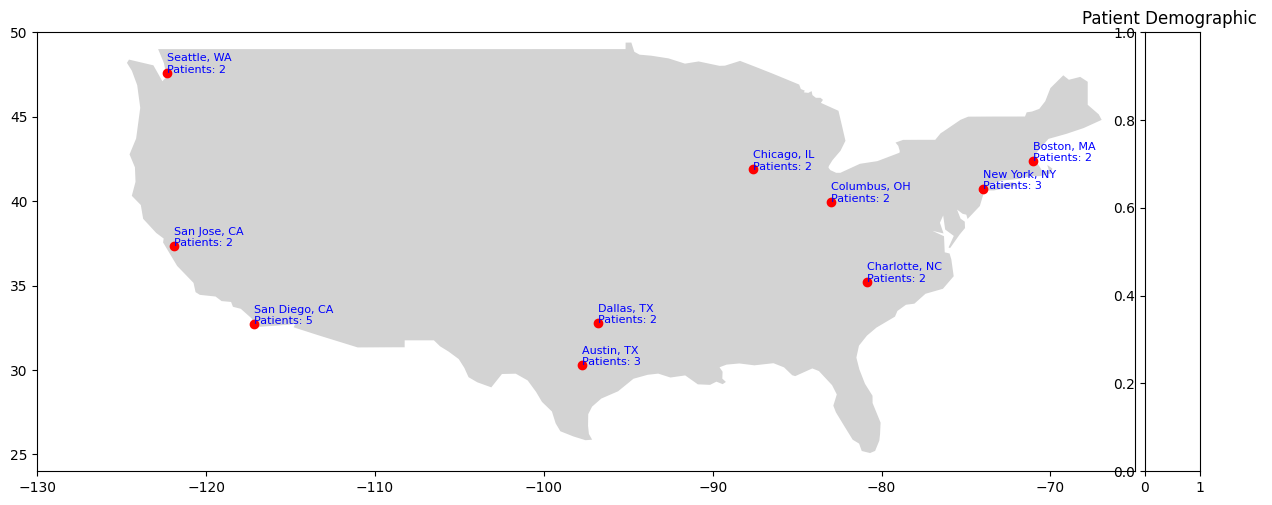

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

gdf = gpd.GeoDataFrame(Patient, geometry=gpd.points_from_xy(Patient['Longitude'], Patient['Latitude']))

# Load a map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter to only show USA
usa = world[world['iso_a3'] == 'USA']

fig, ax = plt.subplots(figsize=(15, 10))
usa.plot(ax=ax, color='lightgrey')

# Setting the bounding box for the USA
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])

# Fixing the aspect ratio
ax.set_aspect('equal')

# Plotting the patient data on the map with labels
gdf.plot(ax=ax, color='red', markersize=10)

# Adding labels and patient count to each point
for idx, row in gdf.iterrows():
    ax.text(row['Longitude'], row['Latitude'], f"{row['City']}, {row['State']}\nPatients: {row['Patient_Count']}", fontsize=8, color='blue')

# Adding a count legend on the side
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

if ax.get_legend():
    ax.get_legend().remove()

gdf.plot(ax=ax, color='red', legend=True, cax=cax)

# Set plot title
plt.title('Patient Demographic ')

# Show the plot
map_plt=plt
map_plt.show()


In [32]:

transaction_type = """
SELECT
    Payment_Mode,
    SUM(Amount) AS Total_Amount_Received
FROM
    Transactions
GROUP BY
    Payment_Mode;
"""

ttype = run_query(transaction_type)
ttype
ttype.sort_values("Total_Amount_Received", inplace=True)
ttype_bar = px.bar(
    ttype, x="Total_Amount_Received", y="Payment_Mode", text="Total_Amount_Received", orientation="h"
)

ttype_bar.update_traces(texttemplate="%{text:.1f}")
chart_width = 800  # Set width
chart_height = 500  # Set height
ttype_bar.update_layout(
    width=chart_width,
    height=chart_height,
)

ttype_bar.show()

In [33]:
staff_count = """
WITH DepartmentCounts AS (
    SELECT
        d.Department_ID,
        d.Department_Name,
        COUNT(DISTINCT doc.Doctor_ID) AS Doctor_Count,
        COUNT(DISTINCT staff.Staff_ID) AS Staff_Count
    FROM
        Department d
    LEFT JOIN
        Doctor doc ON d.Department_ID = doc.Department_ID
    LEFT JOIN
        Staff staff ON d.Department_ID = staff.Department_ID
    GROUP BY
        d.Department_ID, d.Department_Name
)

SELECT
    Department_Name,
    Doctor_Count + Staff_Count AS Total_Count
FROM
    DepartmentCounts;
"""

scount = run_query(staff_count)
scount
staff_count = go.Figure(
    data=[go.Pie(labels=scount["Department_Name"], values=scount["Total_Count"], hole=0)]
)

staff_count.update_layout(title_text="Percentage of People in Each Department")
chart_width = 800  # Set width
chart_height = 500  # Set height
staff_count.update_layout(
    width=chart_width,
    height=chart_height,
)

staff_count.show()

In [34]:
medication = """
WITH MedicalRecordCTE AS (
    SELECT
        Medical_Record.Record_ID,
        CONCAT(Patient.First_Name, ' ', Patient.Last_Name) AS PatientName,
        CONCAT(Doctor.First_Name, ' ', Doctor.Last_Name) AS DoctorName,
        Medical_Record.Record_Date,
        Medical_Record.Diagnosis,
        Medical_Record.Symptoms,
        Prescription.Medication,
        Prescription.Dosage,
        EXTRACT(YEAR FROM Medical_Record.Record_Date) AS Record_Year,
        CONCAT(EXTRACT(YEAR FROM Medical_Record.Record_Date), '-Q',
               EXTRACT(QUARTER FROM Medical_Record.Record_Date)) AS YearQuarter
    FROM
        Hospital_Management.Medical_Record
    INNER JOIN
        Hospital_Management.Prescription ON Medical_Record.Record_ID = Prescription.Record_ID
    INNER JOIN
        Doctor ON Medical_Record.Doctor_ID = Doctor.Doctor_ID
	INNER JOIN
		Patient ON Medical_Record.Patient_ID = Patient.Patient_ID
)

SELECT
    Record_ID,
    PatientName,
    DoctorName,
    Diagnosis,
    Symptoms,
    Medication,
    Dosage,
    YearQuarter,
    COUNT(*) OVER (PARTITION BY Record_Year, YearQuarter) AS Records_Count
FROM
    MedicalRecordCTE;
"""

med_rec = run_query(medication)
med_rec

,Record_ID,PatientName,DoctorName,Diagnosis,Symptoms,Medication,Dosage,YearQuarter,Records_Count
0,7001,Michael Johnson,Dr. Chloe Garcia,Gastritis,"Stomach pain, bloating, nausea",Omeprazole,"20mg, 1 capsule daily before a meal",2022-Q1,5
1,7002,Emily Davis,Dr. Jackson Ward,Influenza,"Fever, body pain, fatigue",Oseltamivir,"75mg, 1 capsule twice daily for 5 days",2022-Q1,5
2,7000,Jane Smith,Dr. Emily Johnson,Common Cold,"Runny nose, sneezing, coughing",Ibuprofen,"200mg, 1 tablet every 4 hours as needed for pain",2022-Q1,5
3,7002,Emily Davis,Dr. Jackson Ward,Influenza,"Fever, body pain, fatigue",Loratadine,"10mg, 1 tablet daily as needed for allergies",2022-Q1,5
4,7001,Michael Johnson,Dr. Chloe Garcia,Gastritis,"Stomach pain, bloating, nausea",Amoxicillin,"500mg, 1 capsule three times daily for 10 days",2022-Q1,5
5,7005,William Wilson,Dr. Lily Taylor,Asthma,"Shortness of breath, congestion",Albuterol Inhaler,2 puffs every 4-6 hours as needed for asthma,2022-Q2,7
6,7004,Olivia Anderson,Dr. Aria King,Autism,"social anxiety, repetitive movements",Ibuprofen,"400mg, 1 tablet every 6 hours as needed for pain",2022-Q2,7
7,7003,David Miller,Dr. Priyansh Lopez,Hypertension,"High blood pressure, headache",Azithromycin,"250mg, 1 tablet daily for 5 days",2022-Q2,7
8,7003,David Miller,Dr. Priyansh Lopez,Hypertension,"High blood pressure, headache",Amlodipine,"5mg, 1 tablet daily in the morning",2022-Q2,7
9,7004,Olivia Anderson,Dr. Aria King,Autism,"social anxiety, repetitive movements",Loratadine,"10mg, 1 tablet daily as needed for allergies",2022-Q2,7


In [35]:
fig = px.treemap(med_rec, path=['Medication'], title='Medication Categories Treemap')

# Show the treemap
medicine_plt=fig
chart_width = 800  # Set width
chart_height = 500  # Set height
medicine_plt.update_layout(
    width=chart_width,
    height=chart_height,
)
medicine_plt.show()

In [36]:
tsa = px.line(med_rec, x='YearQuarter', y='Records_Count', markers=True, line_shape='linear', title='Records Count Over Time')
tsa.update_layout(xaxis_title='YearQuarter', yaxis_title='Records Count')
chart_width = 800  # Set width
chart_height = 500  # Set height
tsa.update_layout(
    width=chart_width,
    height=chart_height,
)
tsa.show()

In [37]:
doctors = tables[tables["TABLE_NAME"] == "Doctor"]["row_count"].values[0]
patients = tables[tables["TABLE_NAME"] == "Patient"]["row_count"].values[0]
departments = tables[tables["TABLE_NAME"] == "Department"]["row_count"].values[0]

In [38]:
import datapane as dp
dp.enable_logging()
r = dp.View(
    dp.Group(
        dp.BigNumber(heading="Total Doctors", value=doctors),
        dp.BigNumber(heading="Total Patients", value=patients),
        dp.BigNumber(heading="Number of Departments", value=departments),
        columns=3,
        name="Little_group",
    ),
    dp.Plot(wordcloud_symptoms, name="wordcloud_symptoms"),
    dp.Group(dp.Plot(appointment_visit), dp.Plot(insurance_plt), dp.Plot(staff_count), dp.Plot(salary_fig), columns=2),
    dp.Group(dp.Plot(medicine_plt), dp.Plot(tsa), dp.Plot(ttype_bar), dp.Plot(ptype_bar), columns=2),
)
dp.save_report(r, path="report.html", open=True)

[22:48:46] [DEBUG] <View version="1" fragment="false">
  <Group name="Little_group" columns="3" valign="top">
    <BigNumber heading="Total Doctors" value="12" is_positive_intent="false" is_upward_change="false"/>
    <BigNumber heading="Total Patients" value="25" is_positive_intent="false" is_upward_change="false"/>
    <BigNumber heading="Number of Departments" value="5" is_positive_intent="false" is_upward_change="false"/>
  </Group>
  <Plot type="application/vnd.plotly.v1+json" name="wordcloud_symptoms" responsive="true" scale="1.0" src="ref://2f6b1d6254"/>
  <Group columns="2" valign="top">
    <Plot type="application/vnd.plotly.v1+json" responsive="true" scale="1.0" src="ref://d53fd1b542"/>
    <Plot type="application/vnd.plotly.v1+json" responsive="true" scale="1.0" src="ref://20fdfe3ce6"/>
    <Plot type="application/vnd.plotly.v1+json" responsive="true" scale="1.0" src="ref://4faef0b175"/>
    <Plot type="application/vnd.plotly.v1+json" responsive="true" scale="1.0" src="ref:/

App saved to ./report.html

In [39]:
import IPython
IPython.display.HTML(filename='report.html')